In [1]:
import yfinance as yf
import pandas as pd
import datetime
from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.cloud import bigquery
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

c:\Users\eliga\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
def train_model(ticker):
   credentials_path = 'C:/Users/eliga/OneDrive/Desktop/Y3S2/BT4222/key.json'
   SERVICE_ACCOUNT_JSON = os.environ["GOOGLE_APPLICATION_CREDENTIALS"]= credentials_path
   client = bigquery.Client.from_service_account_json(SERVICE_ACCOUNT_JSON)
   # dftwitter = pd.read_csv('18feb-19thapr_full.csv')
   # dftwitter['Date'] = pd.to_datetime(dftwitter['Date'])
   
   query_job = client.query("""
      SELECT *
      FROM combined_data.stock_info
      """)
   results = query_job.result()
   df = results.to_dataframe()
   # dfinance = stock_info_daily
   # print(len(dftwitter))
   # df = dftwitter.merge(dfinance,left_on = ['Date','Ticker'],right_on = ['Date','Ticker'])
  
   tickerdf = df[df['Ticker'] == ticker]
   print(len(tickerdf))

   columns = ['Weighted_Compound_Score', 'Open', 'High', 'Low', 'Close', 'Adj_Close','Volume','MA_5days']
   values = tickerdf[columns].astype('float32')
   Y = values.filter(items=['Adj_Close'])
   X = values.filter(columns).drop(columns='Adj_Close')
   # normalize features
   scaler = MinMaxScaler(feature_range=(0, 1))
   X_scaled = scaler.fit_transform(X)
   Y_scaled = scaler.fit_transform(Y)
   split = 30
   x_train, x_test = X_scaled[:split+1,:], X_scaled[split:,:]
   y_train, y_test = Y_scaled[:split+1,:], Y_scaled[split:,:]
   train_X = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
   test_X = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))



   
   # design network
   model = Sequential()
   model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
   model.add(Dense(1))
   model.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
   # fit network
   history = model.fit(train_X, y_train, epochs=50, batch_size=72, validation_data=(test_X, y_test), verbose=2, shuffle=False)

   predictions = model.predict(test_X)
   predictions = scaler.inverse_transform(predictions)
   predictions = predictions[:,0]

   # Get the root mean squared error (RMSE)
   rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
   print(f'rmse: {rmse}')


   train = tickerdf[:split]
   valid = tickerdf[split:]
   valid['Predictions'] = predictions
   # Visualize the data
   plt.figure(figsize=(10,6))
   plt.title('Model')
   plt.xlabel('Date', fontsize=18)
   plt.ylabel('Close Price USD ($)', fontsize=18)
   plt.plot(train['Close'])
   plt.plot(valid[['Close', 'Predictions']])
   plt.legend(['Train', 'Val', 'Predictions'], loc='lower left')
   plt.show()
   model.save(f'{ticker}.h5')
   



84
Epoch 1/50
1/1 - 3s - loss: 0.6442 - accuracy: 0.0645 - val_loss: 0.5943 - val_accuracy: 0.0000e+00 - 3s/epoch - 3s/step
Epoch 2/50
1/1 - 0s - loss: 0.6304 - accuracy: 0.0645 - val_loss: 0.5808 - val_accuracy: 0.0000e+00 - 33ms/epoch - 33ms/step
Epoch 3/50
1/1 - 0s - loss: 0.6165 - accuracy: 0.0645 - val_loss: 0.5673 - val_accuracy: 0.0000e+00 - 43ms/epoch - 43ms/step
Epoch 4/50
1/1 - 0s - loss: 0.6026 - accuracy: 0.0645 - val_loss: 0.5538 - val_accuracy: 0.0000e+00 - 31ms/epoch - 31ms/step
Epoch 5/50
1/1 - 0s - loss: 0.5887 - accuracy: 0.0645 - val_loss: 0.5402 - val_accuracy: 0.0000e+00 - 34ms/epoch - 34ms/step
Epoch 6/50
1/1 - 0s - loss: 0.5747 - accuracy: 0.0645 - val_loss: 0.5266 - val_accuracy: 0.0000e+00 - 31ms/epoch - 31ms/step
Epoch 7/50
1/1 - 0s - loss: 0.5607 - accuracy: 0.0645 - val_loss: 0.5129 - val_accuracy: 0.0000e+00 - 32ms/epoch - 32ms/step
Epoch 8/50
1/1 - 0s - loss: 0.5467 - accuracy: 0.0645 - val_loss: 0.4992 - val_accuracy: 0.0000e+00 - 34ms/epoch - 34ms/step
E

C:\Users\eliga\AppData\Local\Temp/ipykernel_24748/736280149.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


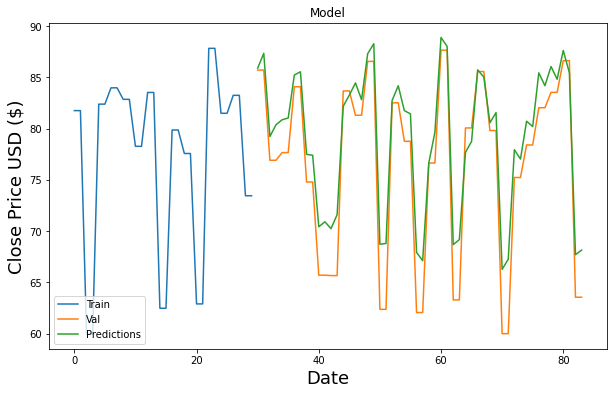

42
Epoch 1/50
1/1 - 2s - loss: 0.3219 - accuracy: 0.0323 - val_loss: 0.3470 - val_accuracy: 0.0000e+00 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 0.3111 - accuracy: 0.0323 - val_loss: 0.3355 - val_accuracy: 0.0000e+00 - 31ms/epoch - 31ms/step
Epoch 3/50
1/1 - 0s - loss: 0.3003 - accuracy: 0.0323 - val_loss: 0.3240 - val_accuracy: 0.0000e+00 - 33ms/epoch - 33ms/step
Epoch 4/50
1/1 - 0s - loss: 0.2896 - accuracy: 0.0323 - val_loss: 0.3124 - val_accuracy: 0.0000e+00 - 33ms/epoch - 33ms/step
Epoch 5/50
1/1 - 0s - loss: 0.2791 - accuracy: 0.0323 - val_loss: 0.3008 - val_accuracy: 0.0000e+00 - 34ms/epoch - 34ms/step
Epoch 6/50
1/1 - 0s - loss: 0.2686 - accuracy: 0.0323 - val_loss: 0.2891 - val_accuracy: 0.0000e+00 - 41ms/epoch - 41ms/step
Epoch 7/50
1/1 - 0s - loss: 0.2580 - accuracy: 0.0323 - val_loss: 0.2774 - val_accuracy: 0.0000e+00 - 32ms/epoch - 32ms/step
Epoch 8/50
1/1 - 0s - loss: 0.2473 - accuracy: 0.0323 - val_loss: 0.2656 - val_accuracy: 0.0000e+00 - 32ms/epoch - 32ms/step
E

C:\Users\eliga\AppData\Local\Temp/ipykernel_24748/736280149.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


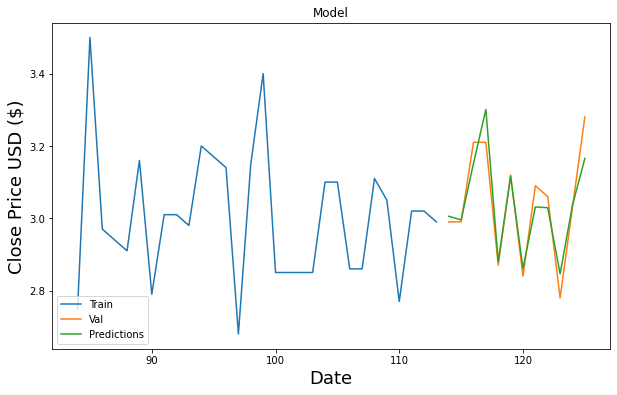

42
Epoch 1/50
1/1 - 2s - loss: 0.5507 - accuracy: 0.0323 - val_loss: 0.6351 - val_accuracy: 0.0000e+00 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 0.5381 - accuracy: 0.0323 - val_loss: 0.6197 - val_accuracy: 0.0000e+00 - 34ms/epoch - 34ms/step
Epoch 3/50
1/1 - 0s - loss: 0.5255 - accuracy: 0.0323 - val_loss: 0.6044 - val_accuracy: 0.0000e+00 - 32ms/epoch - 32ms/step
Epoch 4/50
1/1 - 0s - loss: 0.5130 - accuracy: 0.0323 - val_loss: 0.5890 - val_accuracy: 0.0000e+00 - 34ms/epoch - 34ms/step
Epoch 5/50
1/1 - 0s - loss: 0.5004 - accuracy: 0.0323 - val_loss: 0.5736 - val_accuracy: 0.0000e+00 - 36ms/epoch - 36ms/step
Epoch 6/50
1/1 - 0s - loss: 0.4878 - accuracy: 0.0323 - val_loss: 0.5583 - val_accuracy: 0.0000e+00 - 36ms/epoch - 36ms/step
Epoch 7/50
1/1 - 0s - loss: 0.4751 - accuracy: 0.0323 - val_loss: 0.5429 - val_accuracy: 0.0000e+00 - 38ms/epoch - 38ms/step
Epoch 8/50
1/1 - 0s - loss: 0.4625 - accuracy: 0.0323 - val_loss: 0.5274 - val_accuracy: 0.0000e+00 - 34ms/epoch - 34ms/step
E

C:\Users\eliga\AppData\Local\Temp/ipykernel_24748/736280149.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


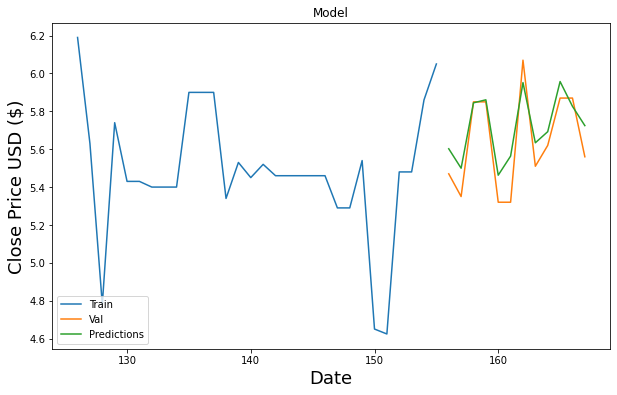

42
Epoch 1/50
1/1 - 3s - loss: 0.5104 - accuracy: 0.0323 - val_loss: 0.4171 - val_accuracy: 0.0000e+00 - 3s/epoch - 3s/step
Epoch 2/50
1/1 - 0s - loss: 0.5003 - accuracy: 0.0323 - val_loss: 0.4070 - val_accuracy: 0.0000e+00 - 27ms/epoch - 27ms/step
Epoch 3/50
1/1 - 0s - loss: 0.4901 - accuracy: 0.0323 - val_loss: 0.3970 - val_accuracy: 0.0000e+00 - 30ms/epoch - 30ms/step
Epoch 4/50
1/1 - 0s - loss: 0.4799 - accuracy: 0.0323 - val_loss: 0.3870 - val_accuracy: 0.0000e+00 - 33ms/epoch - 33ms/step
Epoch 5/50
1/1 - 0s - loss: 0.4698 - accuracy: 0.0323 - val_loss: 0.3770 - val_accuracy: 0.0000e+00 - 32ms/epoch - 32ms/step
Epoch 6/50
1/1 - 0s - loss: 0.4596 - accuracy: 0.0323 - val_loss: 0.3669 - val_accuracy: 0.0000e+00 - 37ms/epoch - 37ms/step
Epoch 7/50
1/1 - 0s - loss: 0.4495 - accuracy: 0.0323 - val_loss: 0.3569 - val_accuracy: 0.0000e+00 - 36ms/epoch - 36ms/step
Epoch 8/50
1/1 - 0s - loss: 0.4393 - accuracy: 0.0323 - val_loss: 0.3468 - val_accuracy: 0.0000e+00 - 30ms/epoch - 30ms/step
E

C:\Users\eliga\AppData\Local\Temp/ipykernel_24748/736280149.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


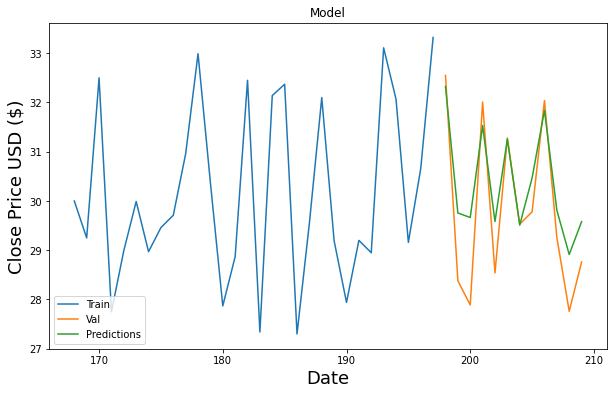

42
Epoch 1/50
1/1 - 2s - loss: 0.5929 - accuracy: 0.0000e+00 - val_loss: 0.5746 - val_accuracy: 0.0833 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 0.5796 - accuracy: 0.0000e+00 - val_loss: 0.5618 - val_accuracy: 0.0833 - 26ms/epoch - 26ms/step
Epoch 3/50
1/1 - 0s - loss: 0.5662 - accuracy: 0.0000e+00 - val_loss: 0.5489 - val_accuracy: 0.0833 - 30ms/epoch - 30ms/step
Epoch 4/50
1/1 - 0s - loss: 0.5529 - accuracy: 0.0000e+00 - val_loss: 0.5361 - val_accuracy: 0.0833 - 53ms/epoch - 53ms/step
Epoch 5/50
1/1 - 0s - loss: 0.5395 - accuracy: 0.0000e+00 - val_loss: 0.5233 - val_accuracy: 0.0833 - 45ms/epoch - 45ms/step
Epoch 6/50
1/1 - 0s - loss: 0.5262 - accuracy: 0.0000e+00 - val_loss: 0.5105 - val_accuracy: 0.0833 - 32ms/epoch - 32ms/step
Epoch 7/50
1/1 - 0s - loss: 0.5129 - accuracy: 0.0000e+00 - val_loss: 0.4976 - val_accuracy: 0.0833 - 30ms/epoch - 30ms/step
Epoch 8/50
1/1 - 0s - loss: 0.4995 - accuracy: 0.0000e+00 - val_loss: 0.4848 - val_accuracy: 0.0833 - 24ms/epoch - 24ms/step
E

C:\Users\eliga\AppData\Local\Temp/ipykernel_24748/736280149.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


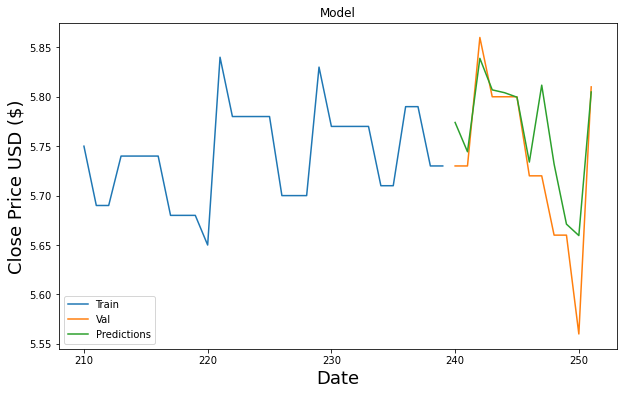

42
Epoch 1/50
1/1 - 3s - loss: 0.4507 - accuracy: 0.0000e+00 - val_loss: 0.5315 - val_accuracy: 0.0833 - 3s/epoch - 3s/step
Epoch 2/50
1/1 - 0s - loss: 0.4383 - accuracy: 0.0000e+00 - val_loss: 0.5191 - val_accuracy: 0.0833 - 27ms/epoch - 27ms/step
Epoch 3/50
1/1 - 0s - loss: 0.4258 - accuracy: 0.0000e+00 - val_loss: 0.5066 - val_accuracy: 0.0833 - 30ms/epoch - 30ms/step
Epoch 4/50
1/1 - 0s - loss: 0.4134 - accuracy: 0.0000e+00 - val_loss: 0.4940 - val_accuracy: 0.0833 - 32ms/epoch - 32ms/step
Epoch 5/50
1/1 - 0s - loss: 0.4009 - accuracy: 0.0000e+00 - val_loss: 0.4815 - val_accuracy: 0.0833 - 36ms/epoch - 36ms/step
Epoch 6/50
1/1 - 0s - loss: 0.3884 - accuracy: 0.0000e+00 - val_loss: 0.4689 - val_accuracy: 0.0833 - 33ms/epoch - 33ms/step
Epoch 7/50
1/1 - 0s - loss: 0.3759 - accuracy: 0.0000e+00 - val_loss: 0.4563 - val_accuracy: 0.0833 - 34ms/epoch - 34ms/step
Epoch 8/50
1/1 - 0s - loss: 0.3633 - accuracy: 0.0000e+00 - val_loss: 0.4436 - val_accuracy: 0.0833 - 31ms/epoch - 31ms/step
E

C:\Users\eliga\AppData\Local\Temp/ipykernel_24748/736280149.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


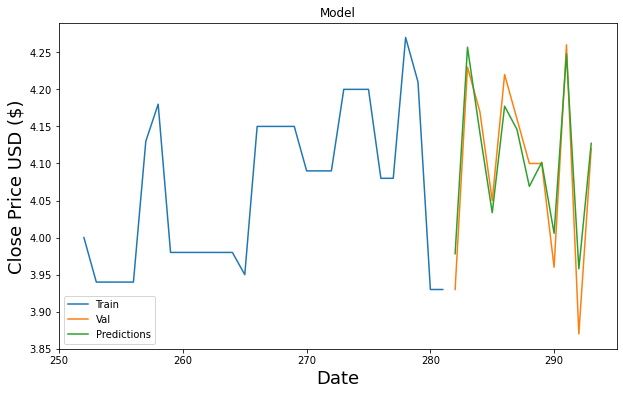

42
Epoch 1/50
1/1 - 2s - loss: 0.2574 - accuracy: 0.0000e+00 - val_loss: 0.3109 - val_accuracy: 0.0833 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 0.2478 - accuracy: 0.0000e+00 - val_loss: 0.2996 - val_accuracy: 0.0833 - 27ms/epoch - 27ms/step
Epoch 3/50
1/1 - 0s - loss: 0.2384 - accuracy: 0.0000e+00 - val_loss: 0.2889 - val_accuracy: 0.0833 - 27ms/epoch - 27ms/step
Epoch 4/50
1/1 - 0s - loss: 0.2292 - accuracy: 0.0000e+00 - val_loss: 0.2788 - val_accuracy: 0.0833 - 30ms/epoch - 30ms/step
Epoch 5/50
1/1 - 0s - loss: 0.2203 - accuracy: 0.0000e+00 - val_loss: 0.2686 - val_accuracy: 0.0833 - 29ms/epoch - 29ms/step
Epoch 6/50
1/1 - 0s - loss: 0.2112 - accuracy: 0.0000e+00 - val_loss: 0.2584 - val_accuracy: 0.0833 - 29ms/epoch - 29ms/step
Epoch 7/50
1/1 - 0s - loss: 0.2022 - accuracy: 0.0000e+00 - val_loss: 0.2481 - val_accuracy: 0.0833 - 29ms/epoch - 29ms/step
Epoch 8/50
1/1 - 0s - loss: 0.1934 - accuracy: 0.0000e+00 - val_loss: 0.2379 - val_accuracy: 0.0833 - 29ms/epoch - 29ms/step
E

C:\Users\eliga\AppData\Local\Temp/ipykernel_24748/736280149.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


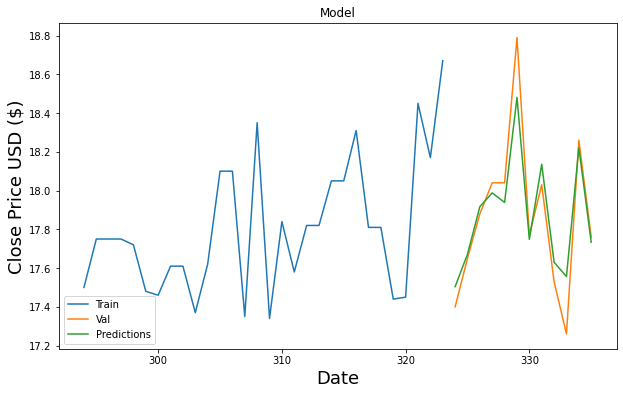

42
Epoch 1/50
1/1 - 2s - loss: 0.3540 - accuracy: 0.0323 - val_loss: 0.5279 - val_accuracy: 0.0000e+00 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 0.3429 - accuracy: 0.0323 - val_loss: 0.5135 - val_accuracy: 0.0000e+00 - 27ms/epoch - 27ms/step
Epoch 3/50
1/1 - 0s - loss: 0.3317 - accuracy: 0.0323 - val_loss: 0.4990 - val_accuracy: 0.0000e+00 - 31ms/epoch - 31ms/step
Epoch 4/50
1/1 - 0s - loss: 0.3206 - accuracy: 0.0323 - val_loss: 0.4845 - val_accuracy: 0.0000e+00 - 27ms/epoch - 27ms/step
Epoch 5/50
1/1 - 0s - loss: 0.3094 - accuracy: 0.0323 - val_loss: 0.4700 - val_accuracy: 0.0000e+00 - 29ms/epoch - 29ms/step
Epoch 6/50
1/1 - 0s - loss: 0.2987 - accuracy: 0.0323 - val_loss: 0.4554 - val_accuracy: 0.0000e+00 - 35ms/epoch - 35ms/step
Epoch 7/50
1/1 - 0s - loss: 0.2883 - accuracy: 0.0323 - val_loss: 0.4407 - val_accuracy: 0.0000e+00 - 52ms/epoch - 52ms/step
Epoch 8/50
1/1 - 0s - loss: 0.2783 - accuracy: 0.0323 - val_loss: 0.4261 - val_accuracy: 0.0000e+00 - 41ms/epoch - 41ms/step
E

C:\Users\eliga\AppData\Local\Temp/ipykernel_24748/736280149.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


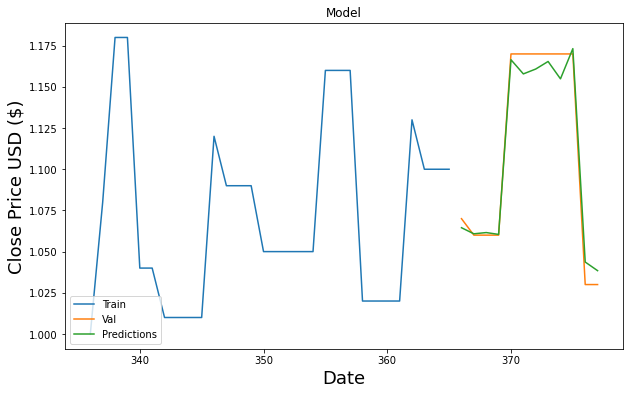

42
Epoch 1/50
1/1 - 3s - loss: 0.5502 - accuracy: 0.0323 - val_loss: 0.5687 - val_accuracy: 0.0000e+00 - 3s/epoch - 3s/step
Epoch 2/50
1/1 - 0s - loss: 0.5387 - accuracy: 0.0323 - val_loss: 0.5560 - val_accuracy: 0.0000e+00 - 29ms/epoch - 29ms/step
Epoch 3/50
1/1 - 0s - loss: 0.5273 - accuracy: 0.0323 - val_loss: 0.5434 - val_accuracy: 0.0000e+00 - 28ms/epoch - 28ms/step
Epoch 4/50
1/1 - 0s - loss: 0.5159 - accuracy: 0.0323 - val_loss: 0.5308 - val_accuracy: 0.0000e+00 - 35ms/epoch - 35ms/step
Epoch 5/50
1/1 - 0s - loss: 0.5044 - accuracy: 0.0323 - val_loss: 0.5182 - val_accuracy: 0.0000e+00 - 40ms/epoch - 40ms/step
Epoch 6/50
1/1 - 0s - loss: 0.4930 - accuracy: 0.0323 - val_loss: 0.5055 - val_accuracy: 0.0000e+00 - 40ms/epoch - 40ms/step
Epoch 7/50
1/1 - 0s - loss: 0.4816 - accuracy: 0.0323 - val_loss: 0.4928 - val_accuracy: 0.0000e+00 - 33ms/epoch - 33ms/step
Epoch 8/50
1/1 - 0s - loss: 0.4701 - accuracy: 0.0323 - val_loss: 0.4801 - val_accuracy: 0.0000e+00 - 32ms/epoch - 32ms/step
E

C:\Users\eliga\AppData\Local\Temp/ipykernel_24748/736280149.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


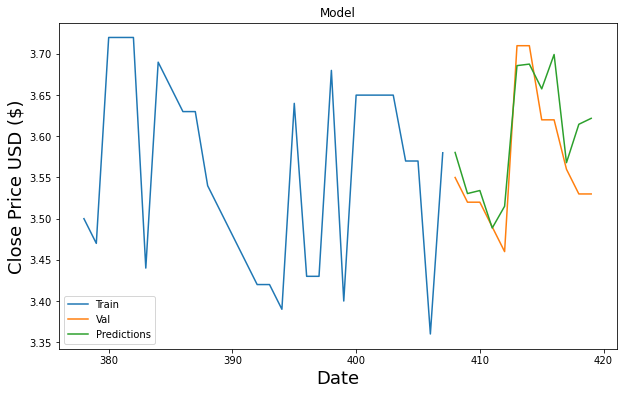

42
Epoch 1/50
1/1 - 2s - loss: 0.4765 - accuracy: 0.0323 - val_loss: 0.4726 - val_accuracy: 0.0000e+00 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 0.4637 - accuracy: 0.0323 - val_loss: 0.4590 - val_accuracy: 0.0000e+00 - 26ms/epoch - 26ms/step
Epoch 3/50
1/1 - 0s - loss: 0.4508 - accuracy: 0.0323 - val_loss: 0.4453 - val_accuracy: 0.0000e+00 - 26ms/epoch - 26ms/step
Epoch 4/50
1/1 - 0s - loss: 0.4379 - accuracy: 0.0323 - val_loss: 0.4316 - val_accuracy: 0.0000e+00 - 29ms/epoch - 29ms/step
Epoch 5/50
1/1 - 0s - loss: 0.4250 - accuracy: 0.0323 - val_loss: 0.4179 - val_accuracy: 0.0000e+00 - 32ms/epoch - 32ms/step
Epoch 6/50
1/1 - 0s - loss: 0.4121 - accuracy: 0.0323 - val_loss: 0.4042 - val_accuracy: 0.0000e+00 - 30ms/epoch - 30ms/step
Epoch 7/50
1/1 - 0s - loss: 0.3996 - accuracy: 0.0323 - val_loss: 0.3905 - val_accuracy: 0.0000e+00 - 30ms/epoch - 30ms/step
Epoch 8/50
1/1 - 0s - loss: 0.3870 - accuracy: 0.0323 - val_loss: 0.3767 - val_accuracy: 0.0000e+00 - 30ms/epoch - 30ms/step
E

C:\Users\eliga\AppData\Local\Temp/ipykernel_24748/736280149.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


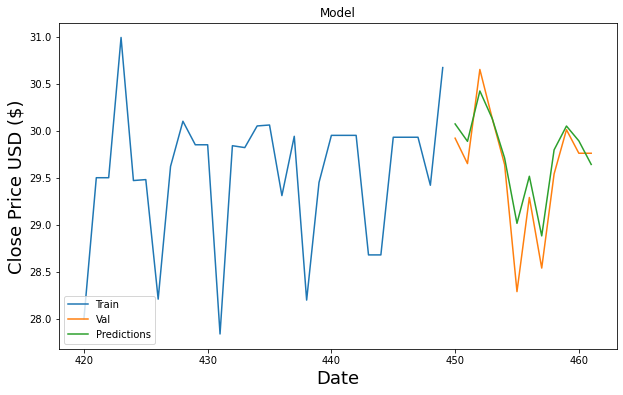

42
Epoch 1/50
1/1 - 3s - loss: 0.4948 - accuracy: 0.0000e+00 - val_loss: 0.5805 - val_accuracy: 0.0833 - 3s/epoch - 3s/step
Epoch 2/50
1/1 - 0s - loss: 0.4834 - accuracy: 0.0000e+00 - val_loss: 0.5678 - val_accuracy: 0.0833 - 31ms/epoch - 31ms/step
Epoch 3/50
1/1 - 0s - loss: 0.4719 - accuracy: 0.0000e+00 - val_loss: 0.5552 - val_accuracy: 0.0833 - 32ms/epoch - 32ms/step
Epoch 4/50
1/1 - 0s - loss: 0.4604 - accuracy: 0.0000e+00 - val_loss: 0.5426 - val_accuracy: 0.0833 - 31ms/epoch - 31ms/step
Epoch 5/50
1/1 - 0s - loss: 0.4489 - accuracy: 0.0000e+00 - val_loss: 0.5299 - val_accuracy: 0.0833 - 31ms/epoch - 31ms/step
Epoch 6/50
1/1 - 0s - loss: 0.4375 - accuracy: 0.0000e+00 - val_loss: 0.5173 - val_accuracy: 0.0833 - 32ms/epoch - 32ms/step
Epoch 7/50
1/1 - 0s - loss: 0.4260 - accuracy: 0.0000e+00 - val_loss: 0.5046 - val_accuracy: 0.0833 - 31ms/epoch - 31ms/step
Epoch 8/50
1/1 - 0s - loss: 0.4144 - accuracy: 0.0000e+00 - val_loss: 0.4919 - val_accuracy: 0.0833 - 30ms/epoch - 30ms/step
E

C:\Users\eliga\AppData\Local\Temp/ipykernel_24748/736280149.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


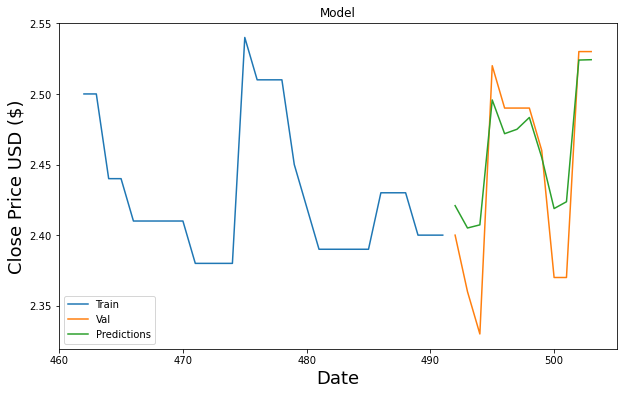

42
Epoch 1/50
1/1 - 2s - loss: 0.4822 - accuracy: 0.0323 - val_loss: 0.5434 - val_accuracy: 0.0000e+00 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 0.4706 - accuracy: 0.0323 - val_loss: 0.5307 - val_accuracy: 0.0000e+00 - 29ms/epoch - 29ms/step
Epoch 3/50
1/1 - 0s - loss: 0.4591 - accuracy: 0.0323 - val_loss: 0.5180 - val_accuracy: 0.0000e+00 - 33ms/epoch - 33ms/step
Epoch 4/50
1/1 - 0s - loss: 0.4479 - accuracy: 0.0323 - val_loss: 0.5053 - val_accuracy: 0.0000e+00 - 26ms/epoch - 26ms/step
Epoch 5/50
1/1 - 0s - loss: 0.4367 - accuracy: 0.0323 - val_loss: 0.4926 - val_accuracy: 0.0000e+00 - 29ms/epoch - 29ms/step
Epoch 6/50
1/1 - 0s - loss: 0.4255 - accuracy: 0.0323 - val_loss: 0.4799 - val_accuracy: 0.0000e+00 - 28ms/epoch - 28ms/step
Epoch 7/50
1/1 - 0s - loss: 0.4143 - accuracy: 0.0323 - val_loss: 0.4672 - val_accuracy: 0.0000e+00 - 29ms/epoch - 29ms/step
Epoch 8/50
1/1 - 0s - loss: 0.4031 - accuracy: 0.0323 - val_loss: 0.4545 - val_accuracy: 0.0000e+00 - 26ms/epoch - 26ms/step
E

C:\Users\eliga\AppData\Local\Temp/ipykernel_24748/736280149.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


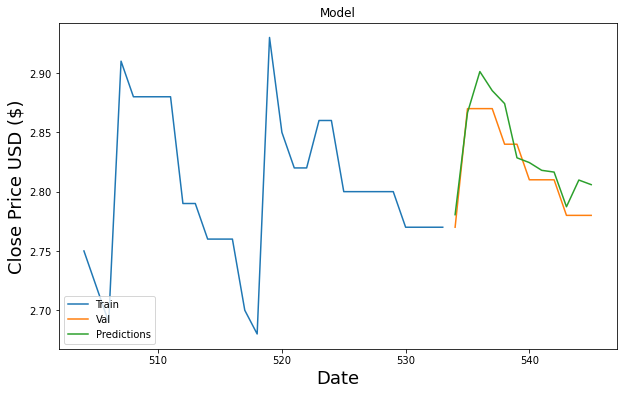

42
Epoch 1/50
1/1 - 2s - loss: 0.5613 - accuracy: 0.0323 - val_loss: 0.6490 - val_accuracy: 0.0000e+00 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 0.5476 - accuracy: 0.0323 - val_loss: 0.6343 - val_accuracy: 0.0000e+00 - 26ms/epoch - 26ms/step
Epoch 3/50
1/1 - 0s - loss: 0.5343 - accuracy: 0.0323 - val_loss: 0.6196 - val_accuracy: 0.0000e+00 - 32ms/epoch - 32ms/step
Epoch 4/50
1/1 - 0s - loss: 0.5210 - accuracy: 0.0323 - val_loss: 0.6049 - val_accuracy: 0.0000e+00 - 29ms/epoch - 29ms/step
Epoch 5/50
1/1 - 0s - loss: 0.5077 - accuracy: 0.0323 - val_loss: 0.5902 - val_accuracy: 0.0000e+00 - 29ms/epoch - 29ms/step
Epoch 6/50
1/1 - 0s - loss: 0.4948 - accuracy: 0.0323 - val_loss: 0.5755 - val_accuracy: 0.0000e+00 - 28ms/epoch - 28ms/step
Epoch 7/50
1/1 - 0s - loss: 0.4819 - accuracy: 0.0323 - val_loss: 0.5609 - val_accuracy: 0.0000e+00 - 26ms/epoch - 26ms/step
Epoch 8/50
1/1 - 0s - loss: 0.4691 - accuracy: 0.0323 - val_loss: 0.5462 - val_accuracy: 0.0000e+00 - 29ms/epoch - 29ms/step
E

C:\Users\eliga\AppData\Local\Temp/ipykernel_24748/736280149.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


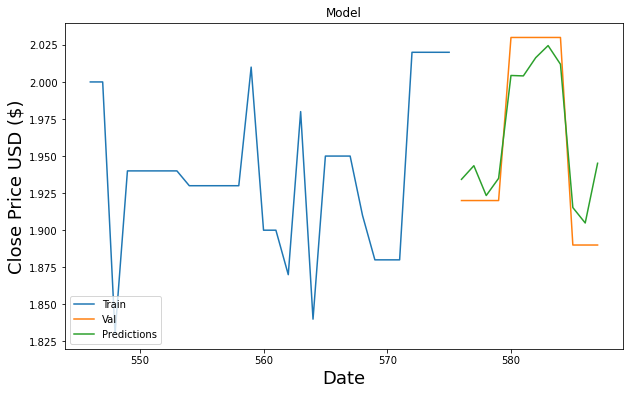

In [6]:
tickerlist =  tickers =  ['SE' ,'GRAB' ,'BN4.SI' ,'C07.SI' ,'C6L.SI' ,'F34.SI' ,'G07.SI' ,'G13.SI' ,'S63.SI' ,'U11.SI' ,'Z74.SI' ,'A17U.SI' ,'C38U.SI']
for ticker in tickerlist:
    train_model(ticker)